In [1]:
%matplotlib inline
# https://stackoverflow.com/questions/16150819/common-xlabel-ylabel-for-matplotlib-subplots

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [3]:
import os
import sys
import git
import pathlib

PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)
    
from libs.constants import model_seeds, error_seeds

In [4]:
model_arch = "fashion-cnn2_1024"

In [5]:
# Load dictionary
model_tag = "fault_injection_analysis_results-fashion_cnn2" 
error_tag = "highERR--ERR1_ERR-1"
# results_tag = 'fault_injection_analysis_results-all_model_seeds--lowerror--' + model_arch

In [6]:
# ERR_TYPE_LIST = [2,3]
# MAX_FAULT_PROB_LIST = [100E-3, 200E-3, 500E-3, 999E-3]
# # Load dictionary
# results_tag = 'fault_injection_analysis_results-all_model_seeds--higherror--' + model_arch

In [7]:
results_folder = pathlib.Path(PROJ_ROOT_PATH / "notebooks"/ model_tag)
results_filename = model_tag + "--" + error_tag + '.npy'
results_file = pathlib.Path(results_folder / results_filename )
result_dict = np.load(str(results_file), allow_pickle='TRUE').item()

In [8]:
MAX_FAULT_PROB_LIST = [100E-3, 200E-3, 500E-3] 
ERR_LIM_list = ["LIM_" + f"{int(MAX_FAULT_PROB*1E3):02d}" for MAX_FAULT_PROB in MAX_FAULT_PROB_LIST]
ERR_PARAM_list = [1,-1]
error_layer_list = ["c0", "c1", "h0", "op", "all"]


In [9]:
fig_values = {}
for ERR_LIM in ERR_LIM_list:
    fig_values[ERR_LIM]={}
    for ERR_PARAM in ERR_PARAM_list:
        fig_values[ERR_LIM][ERR_PARAM]={}
        for error_layer in error_layer_list:
            fig_values[ERR_LIM][ERR_PARAM][error_layer]={"avg":None, "std":None}
            # calculate mean/std for one layer
            dummy = []
            for model_seed in model_seeds:
                for error_seed in error_seeds:
                    error_instance = ERR_LIM + "-"+ str(error_seed)
                    c0_drop = result_dict[model_seed]['original_acc'] - result_dict[model_seed][error_instance][ERR_PARAM][error_layer]
                    dummy.append(c0_drop)
            fig_values[ERR_LIM][ERR_PARAM][error_layer]["avg"] = np.mean(dummy)
            fig_values[ERR_LIM][ERR_PARAM][error_layer]["std"] = np.std(dummy)

Text(0.5, 0.98, 'fashion-cnn2_1024')

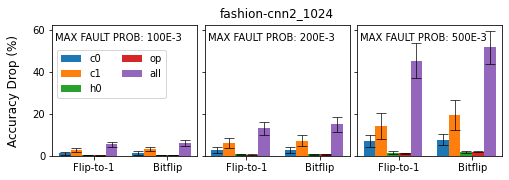

In [22]:
# Plot figure
fig_width = 3.125/0.8 * 2
fig_height = fig_width / 1.618 *0.5
n_rows = 1
n_cols = 3
fig, axs = plt.subplots(nrows=n_rows,
                        ncols=n_cols,
                        figsize=[fig_width,fig_height], # in inches
                        sharex=True,
                        sharey=True,
                        constrained_layout=False, 
                        # tight_layout=True
                       )
plt.subplots_adjust(left=0.1, bottom=None, right=None, top=None, wspace=0.05, hspace=0.1)

for idx, ERR_LIM in enumerate(ERR_LIM_list):
    # row = idx//n_cols
    # col = idx%n_cols
    # ax = axs[row][col]
    ax = axs[idx]
    text = "MAX FAULT PROB: " + f"{int(MAX_FAULT_PROB_LIST[idx]*1E3):01d}" +"E-3"
    ax.text(0.02, 0.9, 
           text, 
           horizontalalignment='left', 
           verticalalignment='center', 
           transform=ax.transAxes)
    yticks = np.arange(4)*0.2
    ax.set_yticks(yticks,
                 labels = [f"{int(tick*1E2):01d}" for tick in yticks]) 
    
    xticks = np.arange(len(ERR_PARAM_list)) +0.4
    ax.set_xticks(xticks,
                 labels = ["Flip-to-1", "Bitflip"],
                  rotation=0) 

    for idx, layer in enumerate(error_layer_list):
        layers_avgs = [fig_values[ERR_LIM][ERR_PARAM][layer]["avg"] for ERR_PARAM in ERR_PARAM_list]
        layers_stds = [fig_values[ERR_LIM][ERR_PARAM][layer]["std"] for ERR_PARAM in ERR_PARAM_list]

        x_roots = np.arange(len(ERR_PARAM_list))  # the label locations
        width = 0.8 # width of stacked bar
        bar_width = width/len(error_layer_list)
        x_offsets = idx * bar_width
        x_poss = x_roots + x_offsets
        rects1 = ax.bar(x_poss, 
                        layers_avgs,
                        yerr=layers_stds,
                        label=layer, 
                        width=bar_width,
                       error_kw=dict(ecolor='black', lw=1, capsize=5, capthick=1, alpha=0.7))
axs[0].legend(loc="lower left",
                ncol=2,
                bbox_to_anchor=(0,0.4, 1, 1))

# fig.supxlabel('Error Type');
fig.supylabel('Accuracy Drop (%)');
fig.suptitle(model_arch)

In [13]:
# Get notebook path
import ipynbname
nb_path = str(ipynbname.path())
fig_filename_tag = model_tag + "--" + error_tag
fig_folder = pathlib.Path(PROJ_ROOT_PATH / "figures")
pathlib.Path(fig_folder).mkdir(parents=True, exist_ok=True)
fig_filename = pathlib.Path(fig_folder/ fig_filename_tag)
print(fig_filename)
fig.savefig(fig_filename,
    # pathlib.Path(fig_filename).with_suffix(".png"), 
            dpi=300, 
            bbox_inches='tight', 
            transparent=True, 
            metadata={"genfilepath": nb_path})

/repos/faulty_cnn/figures/fault_injection_analysis_results-fashion_cnn2--highERR--ERR1_ERR-1
